# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from substitutors import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = 'line3' # Mouse line
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.ZSCORE  # variable of interest for post-processing

### Derived parameters

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
figs_suffix = f'{mouseline}_k{kalman_gain}_{postpro_id}'
submap = [(1, 0), (FrameIndex.STIM - 1, FrameIndex.STIM)]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, baseline_id, kd.code, ss.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{mouseline} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 27/05/2022 14:18:39: line3 batch notebook started on 2022-05-27 at 14:18:39


### Input summary table figure

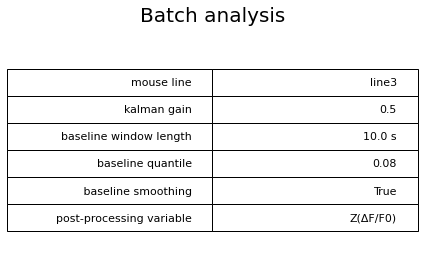

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

### Load data

In [6]:

logger.info(f'loading data from {trialavg_dir}:')
data = load_datasets(trialavg_dir)
timeseries = data['timeseries']
stats = data['stats']
stats

 27/05/2022 14:18:44: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/line3:
 27/05/2022 14:18:44: loading timeseries data from timeseries_20191112_mouse12_region1.csv
 27/05/2022 14:18:45: loading stats data from stats_20191112_mouse12_region1.csv
 27/05/2022 14:18:45: sorting dataset indexes...
 27/05/2022 14:18:45: adding diff Z(ΔF/F0) metrics to stats dataset...
 27/05/2022 14:18:45: applying <lambda> function on Z(ΔF/F0) in 1-11 index window across dataset, ROI, run ...
 27/05/2022 14:18:45: identified outputs in 6570/6570 windows (100.0 %)
 27/05/2022 14:18:45: applying <lambda> function on Z(ΔF/F0) in 10-20 index window across dataset, ROI, run ...
 27/05/2022 14:18:45: identified outputs in 6570/6570 windows (100.0 %)
 27/05/2022 14:18:45: adding diff ΔF/F0 metrics to stats dataset...
 27/05/2022 14:18:45: applying <lambda> function on ΔF/F0 in 1-11 index window across dataset, ROI, run ...


line  trial_length  duration (s)   fps  \
dataset                  ROI run                                            
20191112_mouse12_region1 3   0    line3         100.0           0.2  3.56   
                             1    line3         100.0           0.2  3.56   
                             2    line3         100.0           0.2  3.56   
                             3    line3         100.0           0.2  3.56   
                             4    line3         100.0           0.2  3.56   
...                                 ...           ...           ...   ...   
                         877 10   line3         100.0           0.2  3.56   
                             11   line3         100.0           0.2  3.56   
                             12   line3         100.0           0.2  3.56   
                             13   line3         100.0           0.2  3.56   
                             14   line3         100.0           0.2  3.56   

                                  P (MPa)  DC (%)  run ID  I_SPPA (W/cm2)  \
dataset                  ROI run                                            
20191112_mouse12_region1 3   0       0.00    50.0   869.0        0.000000   
                             1       0.10    50.0   867.0        0.309132   
                             2       0.20    50.0   866.0        1.236530   
                             3       0.40    50.0   865.0        4.946119   
                             4       0.05    50.0   868.0        0.077283   
...                                   ...     ...     ...             ...   
                         877 10      0.80    40.0   856.0       19.784475   
                             11      0.80    50.0   855.0       19.784475   
                             12      0.80    60.0   861.0       19.784475   
                             13      0.80    70.0   862.0       19.784475   
                             14      0.80    80.0   863.0       19.784475   

                                  I_SPTA (W/cm2)  \
dataset                  ROI run                   
20191112_mouse12_region1 3   0          0.000000   
                             1          0.154566   
                             2          0.618265   
                             3          2.473059   
                             4          0.038642   
...                                          ...   
                         877 10         7.913790   
                             11         9.892238   
                             12        11.870685   
                             13        13.849133   
                             14        15.827580   

                                  peak displacement velocity (um/s)  ...  \
dataset                  ROI run                                     ...   
20191112_mouse12_region1 3   0                             0.330863  ...   
                             1                             0.479668  ...   
                             2                             0.473297  ...   
                             3                             0.603792  ...   
                             4                             0.445831  ...   
...                                                             ...  ...   
                         877 10                            0.788509  ...   
                             11                            1.198864  ...   
                             12                            1.624412  ...   
                             13                            1.172224  ...   
                             14                            1.301401  ...   

                                  post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) pval  \
dataset                  ROI run                                                        
20191112_mouse12_region1 3   0                                             0.000155     
                             1                                             0.982434     
         

### Breakdown per mouse region

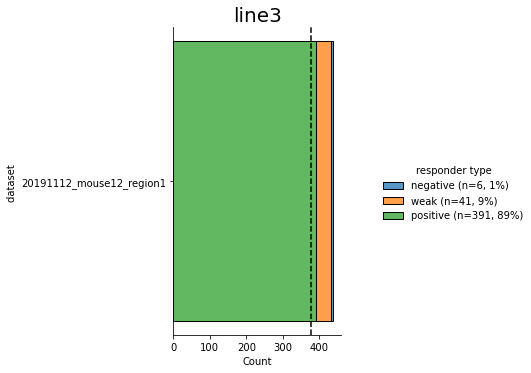

In [7]:
# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = MIN_CELL_DENSITY * area
# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count,
    title=mouseline)

### Exclude datasets with low cell count

In [8]:
# Idendify datasets with a low overall cell count
celltypes = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = celltypes.groupby(Label.DATASET).count().iloc[:, 0].rename('counts')
to_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()

# Exclude them
data = exclude_datasets(data.copy(), to_exclude)
timeseries = data['timeseries']
stats = data['stats']

 27/05/2022 14:18:50: did not find any datasets to exclude


### Parameter dependency curves

 27/05/2022 14:18:52: sub-indexing data...
 27/05/2022 14:18:52: filtering data...
 27/05/2022 14:18:52: cross-checking filters...
 27/05/2022 14:18:52: grouping by responder type, grouping by dataset, averaging, estimating confidence intervals and plotting mean diff Z(ΔF/F0) vs. P (MPa) ...
 27/05/2022 14:18:53: sub-indexing data...
 27/05/2022 14:18:53: filtering data...
 27/05/2022 14:18:53: cross-checking filters...
 27/05/2022 14:18:53: grouping by responder type, grouping by dataset, averaging, estimating confidence intervals and plotting mean diff Z(ΔF/F0) vs. DC (%) ...


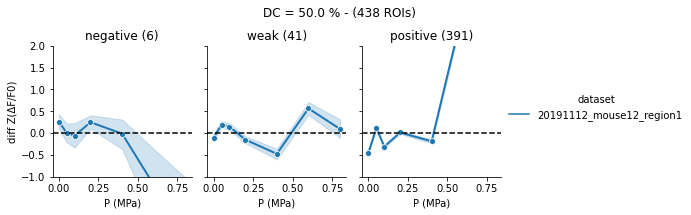

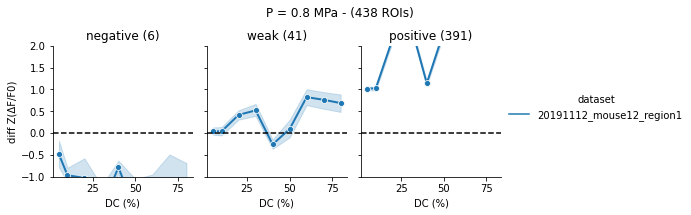

In [9]:
for pkey in [Label.P, Label.DC]:
    figs[f'{pkey}-dep {ykey_postpro}'] = plot_parameter_dependency_across_datasets(
        stats, pkey, ykey_postpro)

### Get plot-ready traces dataset

In [10]:
plt_data = get_plot_data(timeseries, stats)

 27/05/2022 14:23:37: merging timeseries and stats information...
 27/05/2022 14:23:40: adding time info to table...


### Pressure-dependent response traces

 27/05/2022 14:23:53: plotting P (MPa) dependency curves for negative responders...
 27/05/2022 14:23:53: sub-indexing data...
 27/05/2022 14:23:53: filtering data...
 27/05/2022 14:23:53: cross-checking filters...
 27/05/2022 14:23:53: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 27/05/2022 14:23:53: plotting P (MPa) dependency curves for positive responders...
 27/05/2022 14:23:53: sub-indexing data...
 27/05/2022 14:23:53: filtering data...
 27/05/2022 14:23:53: cross-checking filters...
 27/05/2022 14:23:53: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 27/05/2022 14:23:55: plotting P (MPa) dependency curves for weak responders...
 27/05/2022 14:23:55: sub-indexing data...
 27/05/2022 14:23:55: filtering data...
 27/05/2022 14:23:55: cross-checking filters...
 27/05/2022 14:23:55: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


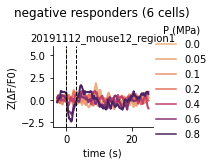

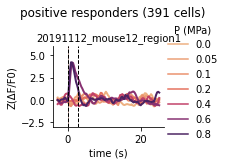

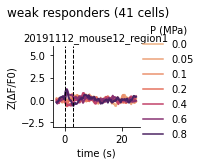

In [11]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

### DC-dependent response traces

 27/05/2022 14:24:11: plotting DC (%) dependency curves for negative responders...
 27/05/2022 14:24:11: sub-indexing data...
 27/05/2022 14:24:11: filtering data...
 27/05/2022 14:24:11: cross-checking filters...
 27/05/2022 14:24:11: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 27/05/2022 14:24:12: plotting DC (%) dependency curves for positive responders...
 27/05/2022 14:24:12: sub-indexing data...
 27/05/2022 14:24:12: filtering data...
 27/05/2022 14:24:12: cross-checking filters...
 27/05/2022 14:24:12: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 27/05/2022 14:24:14: plotting DC (%) dependency curves for weak responders...
 27/05/2022 14:24:14: sub-indexing data...
 27/05/2022 14:24:14: filtering data...
 27/05/2022 14:24:14: cross-checking filters...
 27/05/2022 14:24:14: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


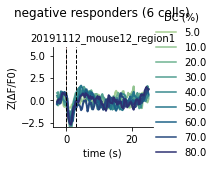

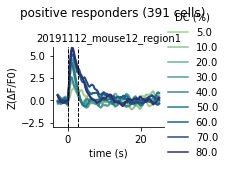

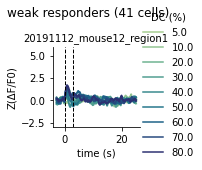

In [12]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

### Average response traces across datasets (weighted)

 27/05/2022 14:24:20: sub-indexing data...
 27/05/2022 14:24:20: filtering data...
 27/05/2022 14:24:20: cross-checking filters...
 27/05/2022 14:24:20: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 27/05/2022 14:24:22: sub-indexing data...
 27/05/2022 14:24:23: filtering data...
 27/05/2022 14:24:23: cross-checking filters...
 27/05/2022 14:24:23: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


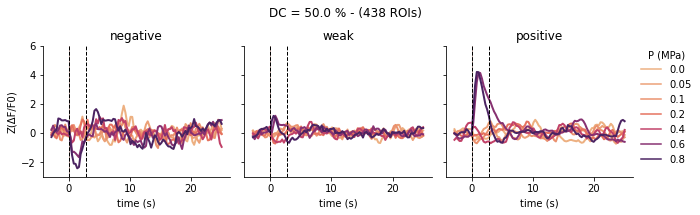

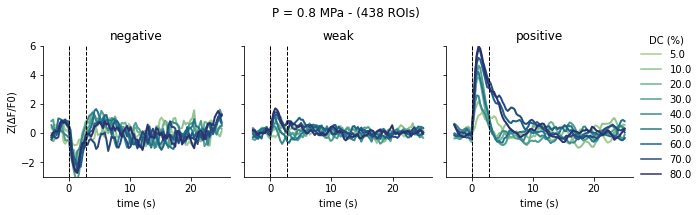

In [13]:
# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - weighted'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Average response traces across datasets (non-weighted)

 27/05/2022 14:24:31: checking for run order consistency across datasets...
 27/05/2022 14:24:31: computing average traces per dataset and condition...
 27/05/2022 14:24:31: sub-indexing data...
 27/05/2022 14:24:31: filtering data...
 27/05/2022 14:24:31: cross-checking filters...
 27/05/2022 14:24:31: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 27/05/2022 14:24:32: sub-indexing data...
 27/05/2022 14:24:32: filtering data...
 27/05/2022 14:24:32: cross-checking filters...
 27/05/2022 14:24:32: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


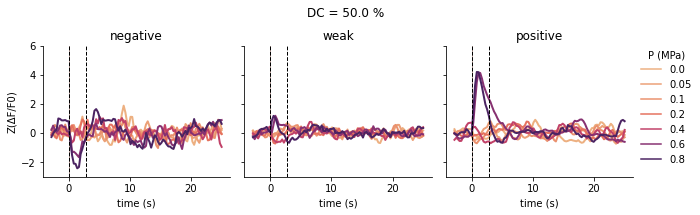

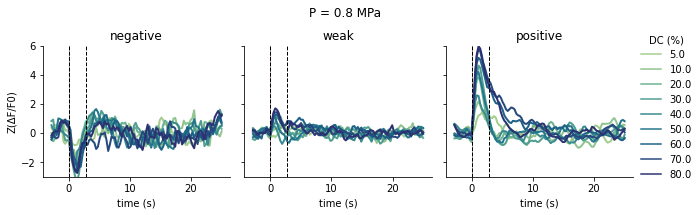

In [14]:
# Check run order consistency across datasets
logger.info('checking for run order consistency across datasets...')
params_per_run = plt_data.groupby([Label.DATASET, Label.RUN]).first()[[Label.P, Label.DC]]
for k in params_per_run:
    sum_of_stds = params_per_run[k].unstack().std().sum()
    if sum_of_stds > 1e-12:
        logger.error('variation in run orders across dataset')

# Group data by mouse-region, response type, run and frame -> average
logger.info('computing average traces per dataset and condition...')
avg_plt_data = plt_data.groupby(
    [Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR, Label.TIME])

# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - nonweighted'] = plot_responses_across_datasets(
        avg_plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Save figures

In [15]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 26/05/2022 15:22:29: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.05.26/figs_line3_k0.5_w10.0s_q0.08_smooth_Z(ΔFF0).pdf:


100%|██████████| 14/14 [00:02<00:00,  6.94it/s]


### Notify upon completion

In [16]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 26/05/2022 15:22:31: line3 batch notebook completed in 0:04:22.493051 s
